In [1]:
import pandas as pd
import polars as pl
import polars.selectors as cs
import numpy as np
import plotnine as pn
from mizani.formatters import comma_format, custom_format, currency_format, percent_format
from IPython.display import clear_output, display
import os
from skimpy import clean_columns

# Actually needed for script
import requests
from bs4 import BeautifulSoup
import datetime


jama_colour = [
    "#374e55",
    "#df8f44",
    "#00a1d5",
    "#b24745",
    "#79af97",
]

pd.set_option("display.max.columns", 500)
pd.set_option("display.max.columns", 500)
background_colour = "#F2F2F2"
pn.theme_set(
    pn.theme_classic()
    + pn.theme(
        figure_size=[7, 7/1.618],
        text=pn.element_text(family="monospace"),
        plot_background=pn.element_rect(
            fill=background_colour, colour=background_colour
        ),
        panel_background=pn.element_rect(
            fill=background_colour, colour=background_colour
        ),
        legend_background=pn.element_rect(
            fill=background_colour, colour=background_colour
        ),
    )
)


%load_ext blackcellmagic
%matplotlib inline

In [15]:
url = "https://www.unibe.ch/universitaet/campus__und__infrastruktur/universitaetssport/sportangebot/fitnessraeume/readhtml2?decoding=utf-8&url=https://www.zssw.unibe.ch/usp/zms/templates/crowdmonitoring/_display-spaces-zssw.php"

try:
    response = requests.get(url, timeout=100)  # Timeout set to 100 seconds
    response.raise_for_status()  # Raise an exception for HTTP errors

    # Parse the HTML
    soup = BeautifulSoup(response.text, "html.parser")

    # Find the element with class 'go-stop-display_footer'
    footer_div = soup.find("div", class_="go-stop-display_footer")

    # Extract the text content
    text_content = footer_div.get_text(strip=True)

    # Get the occupancy numbers
    occupancy_numbers = [x.strip() for x in text_content.split("von")]

    # Concatenate old data with the newly observed line
    df_out = pd.concat(
        [
            pd.read_csv("data.csv", parse_dates=["datetime"]),
            pd.DataFrame(
                [
                    {
                        "datetime": pd.Timestamp(datetime.datetime.today())
                        .tz_localize(tz="UTC")
                        .tz_convert("Europe/Zurich"),
                        "actual_occupancy": occupancy_numbers[0],
                        "max_occupancy": occupancy_numbers[1],
                    }
                ]
            ),
        ]
    )

    # Write the data to a CSV file
    df_out.to_csv("data.csv", index=False)

except requests.exceptions.RequestException as e:
    print("Error:", e)

In [17]:
df = (
    pl.read_csv("data.csv")
    .with_columns(pl.col("datetime").str.to_datetime())
    .with_columns(
        pl.col("datetime").dt.convert_time_zone("Europe/Zurich").dt.truncate("5m")
    )
    .unique()
)

df.head()

datetime,actual_occupancy,max_occupancy
"datetime[μs, Europe/Zurich]",i64,i64
2024-03-01 22:45:00 CET,3,80
2024-03-01 23:55:00 CET,3,80
2024-03-02 01:45:00 CET,3,80
2024-03-02 04:00:00 CET,3,80
2024-03-02 05:40:00 CET,0,80


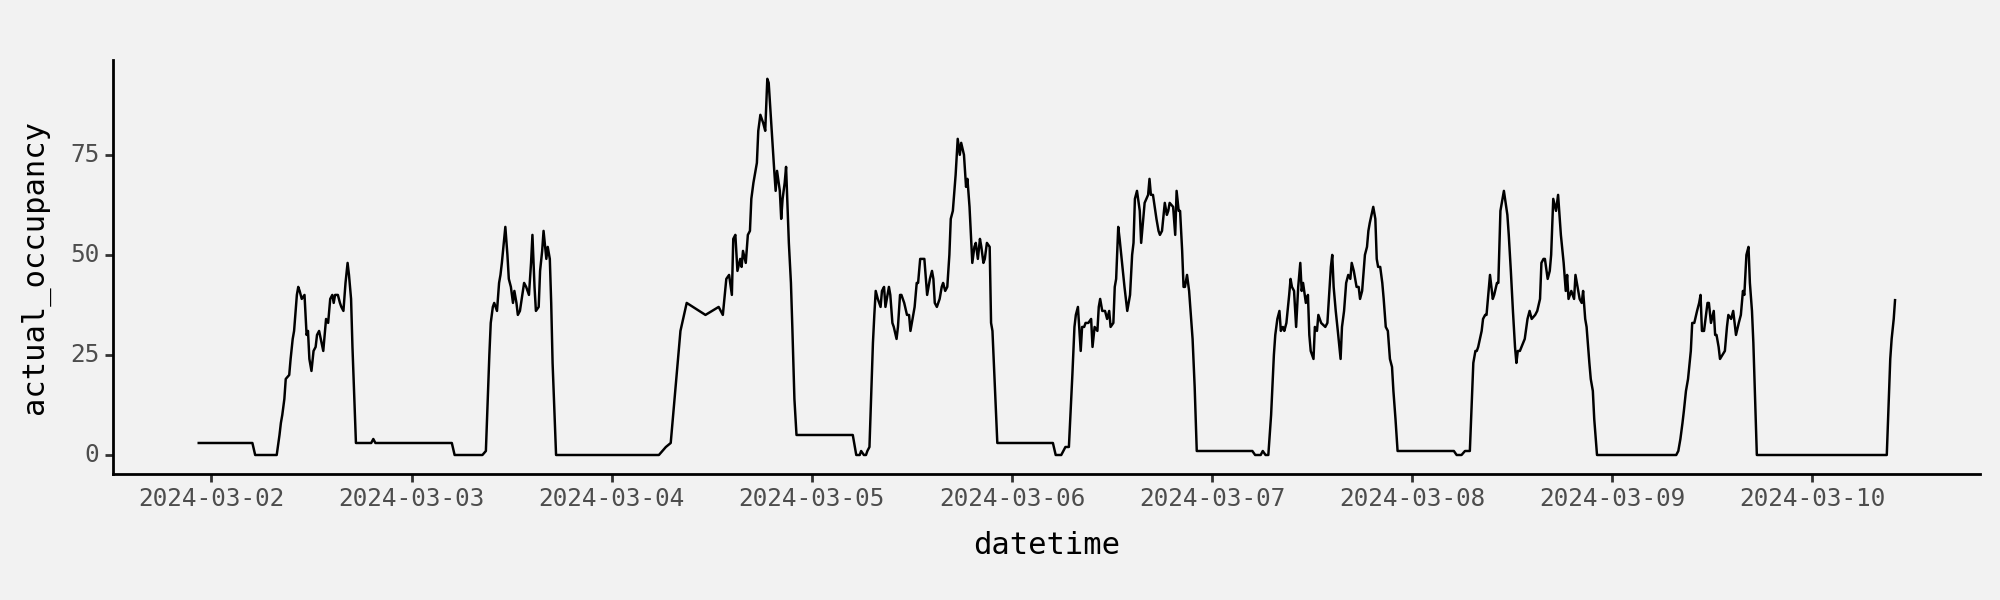

<Figure Size: (1000 x 300)>

In [22]:
(
    pn.ggplot(data=df, mapping=pn.aes(x="datetime", y="actual_occupancy"))
    + pn.geom_line()
    + pn.theme(figure_size=[10, 3])
)